# Prediction of protein subcellular localisation - Jorge Martínez (M2BI)

## Load modules

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data processing and analysis
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from scipy.ndimage import gaussian_filter1d

# Deep learning framework
import tensorflow as tf
from tensorflow import keras

# Keras modules
from keras import layers, models, utils, callbacks, optimizers
from keras.models import Sequential, Model
from keras.layers import (
    Dense, Dropout, Add, Permute, Activation, Input,
    Conv1D, MaxPooling1D, BatchNormalization, AveragePooling1D, Concatenate,
    Flatten
)
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from scikeras import wrappers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection     import KFold
from sklearn.model_selection     import cross_val_score

# Visualization
import seaborn as sns

## Load data and take a first look

In [2]:
# Load the data
train = np.load("../data/reduced_train.npz")
test = np.load("../data/reduced_val.npz")

# Create the x and y data for the train and test sets
x_train = train['X_train']
y_train = train['y_train']

x_test = test['X_val']
y_test = test['y_val']

# Basic Information
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

# Data Types
print("\nData types:")
print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)

# Missing Values
print("\nMissing values in x_train:", np.isnan(x_train).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())

Shape of x_train: (2423, 400, 20)
Shape of y_train: (2423,)
Shape of x_test: (635, 400, 20)
Shape of y_test: (635,)

Data types:
x_train dtype: float32
y_train dtype: int32

Missing values in x_train: 0
Missing values in y_train: 0


In [3]:
# Sample Data
print("\nFirst 5 rows of x_train:")
print(x_train[:5])
print("\nFirst 5 rows of y_train:")
print(y_train[:5])


First 5 rows of x_train:
[[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0. 


Class distribution in y_train:
Class 0: 338 samples
Class 1: 567 samples
Class 2: 535 samples
Class 3: 233 samples
Class 4: 285 samples
Class 5: 63 samples
Class 6: 224 samples
Class 7: 59 samples
Class 8: 60 samples
Class 9: 59 samples


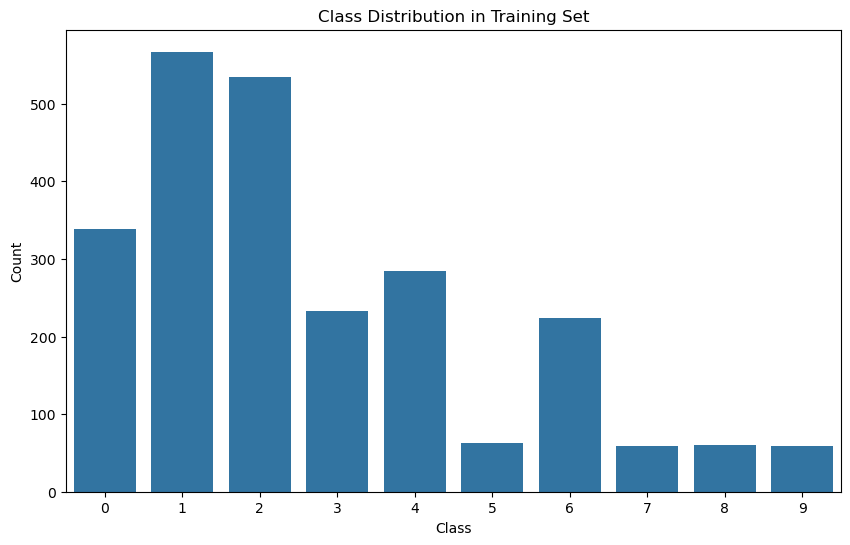

In [4]:
# Class Distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\nClass distribution in y_train:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")
    
# Plot Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [5]:
# One hot encoding
num_classes = len(np.unique(y_train))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Base

### DNN

In [6]:
def dnn_model():
    model = Sequential([
        Input(shape=(400,20)),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

# Create the model 
model_dnn = dnn_model()
model_dnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       256,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,362 (1001.41 KB)

 Trainable params: 256,362 (1001.41 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callback = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                patience = 5,
                                mode = 'max',
                                restore_best_weights=True)

history_dnn = model_dnn.fit(x_train, y_train, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2,
                    callbacks = [callback])

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1751 - loss: 2.2387 - val_accuracy: 0.3567 - val_loss: 2.0761
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3141 - loss: 2.0309 - val_accuracy: 0.3711 - val_loss: 1.9627
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3949 - loss: 1.8562 - val_accuracy: 0.4330 - val_loss: 1.8367
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4501 - loss: 1.7421 - val_accuracy: 0.4845 - val_loss: 1.7427
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5211 - loss: 1.5789 - val_accuracy: 0.5361 - val_loss: 1.6480
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5619 - loss: 1.4598 - val_accuracy: 0.5711 - val_loss: 1.5757
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5948 - loss: 1.3580 - val_accuracy: 0.5732 - val_loss: 1.5112
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6215 - loss: 1.3011 - val_accuracy: 0.5918 - val_loss:

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.7211 - loss: 0.8720
Test accuracy: 0.7213


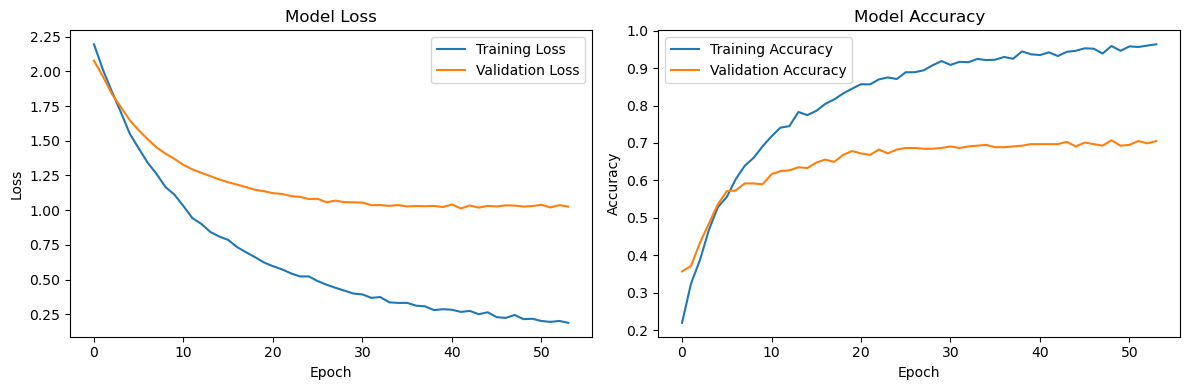

In [8]:
# Evaluate the model
test_loss_dnn, test_accuracy_dnn = model_dnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


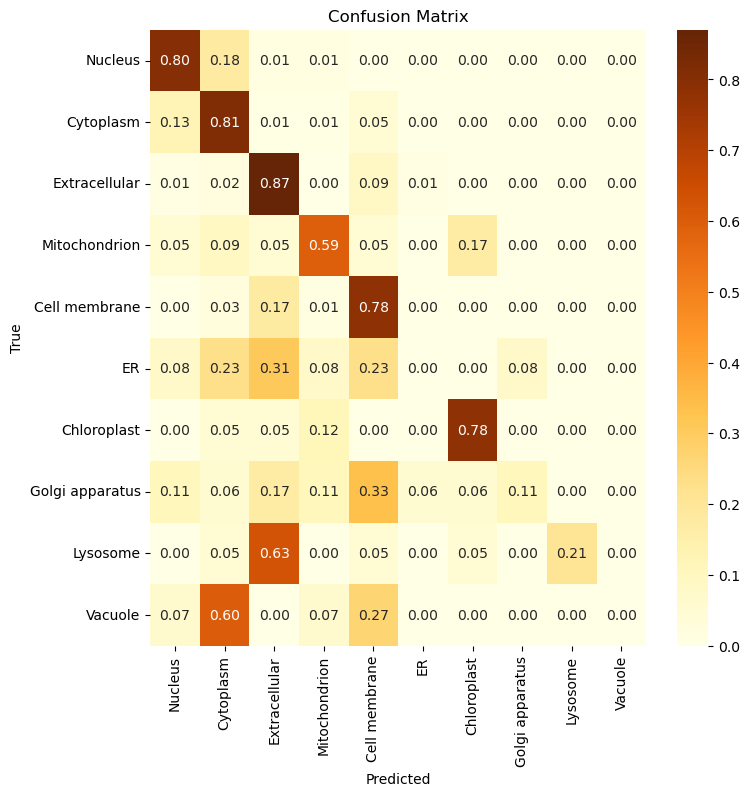

In [9]:
# Make predictions
y_pred = model_dnn.predict(x_test)


# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Save the model
# model_dnn.save('../res/model_dnn.h5')

### CNN

In [11]:
def cnn_model():
    model = Sequential([
        Input(shape=(400,20)),
        Conv1D(32,
               kernel_size=3,
               padding='same',
               activation='relu'),
        AveragePooling1D(pool_size=2),
        Dropout(0.5),
        BatchNormalization(),
        
        Conv1D(64,
               kernel_size=5,
               padding='same',
               activation='relu'),
        AveragePooling1D(pool_size=2),
        Dropout(0.5),
        BatchNormalization(),
        Flatten(),
        Dense(num_classes, activation="softmax")
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Create the model
model_cnn = cnn_model()
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 400, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 200, 32)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 100, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        64,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,650 (299.41 KB)

 Trainable params: 76,458 (298.66 KB)

 Non-trainable params: 192 (768.00 B)

In [12]:
history_cnn = model_cnn.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.2025 - loss: 2.6534 - val_accuracy: 0.2268 - val_loss: 2.2156
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2936 - loss: 2.1898 - val_accuracy: 0.2268 - val_loss: 2.2079
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3869 - loss: 1.8210 - val_accuracy: 0.2268 - val_loss: 2.2410
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4553 - loss: 1.5927 - val_accuracy: 0.2268 - val_loss: 2.2876
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5198 - loss: 1.4455 - val_accuracy: 0.2268 - val_loss: 2.3360
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6002 - loss: 1.2425 - val_accuracy: 0.2289 - val_loss: 2.4861
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6474 - loss: 1.0414 - val_accuracy: 0.2268 - val_loss: 2.6753
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6716 - loss: 0.9877 - val_accuracy: 0.2268 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8175 - loss: 0.7387
Test accuracy: 0.8205


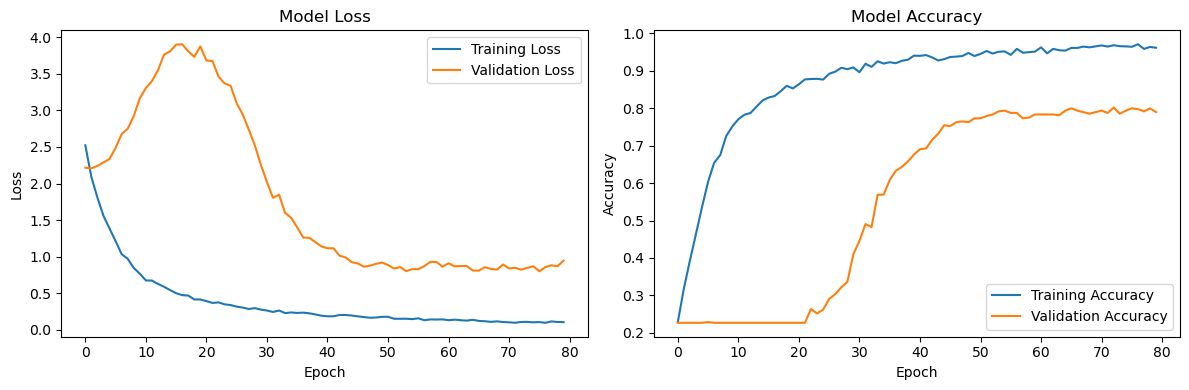

In [13]:
# Evaluate the model
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


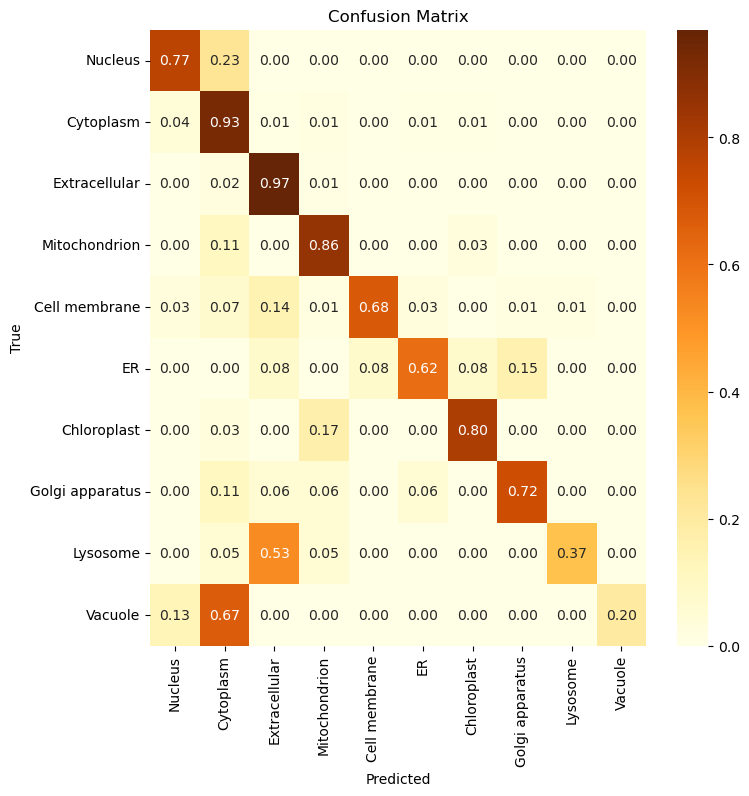

In [14]:
# Make predictions
y_pred = model_cnn.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Save the model
# model_cnn.save('../res/model_cnn.h5')

### CNN - functional API

In [16]:
def cnn_api_model():
    inputs = Input(shape=(400,20))
    
    # Make two parallel convolutional layers with different kernel sizes
    conv_1 = Conv1D(32,
                    kernel_size=3,
                    padding="same",
                    activation="relu")(inputs)
    conv_2 = Conv1D(32,
                    kernel_size=5,
                    padding="same",
                    activation="relu")(inputs)
    
    convs = Concatenate(axis=1)([conv_1, conv_2])
    
    # Second simple convolutional layer
    conv_3 = Conv1D(64,
                    kernel_size=3,
                    padding="same",
                    activation="relu")(convs)
    
    # Reduce dimensions
    max_pool = MaxPooling1D(pool_size = 5)(conv_3)
    
    # Flatten to apply a dense layer
    flat = Flatten()(max_pool)
    dense = Dense(32, activation="relu")(flat)
    drop = Dropout(0.5)(dense)
    
    # Output layer
    outputs = Dense(num_classes, activation="softmax")(drop)
    
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Create the model
model_cnn_api = cnn_api_model()
model_cnn_api.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 400, 32)   │      1,952 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 400, 32)   │      3,232 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 800, 32)   │          0 │ conv1d_2[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 800, 64)   │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 160, 64)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 10240)     │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │    327,712 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10)        │        330 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 339,434 (1.29 MB)

 Trainable params: 339,434 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_cnn_api = model_cnn_api.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.2055 - loss: 2.1892 - val_accuracy: 0.3175 - val_loss: 2.0119
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.2652 - loss: 2.0374 - val_accuracy: 0.2969 - val_loss: 1.9331
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3092 - loss: 1.9441 - val_accuracy: 0.3237 - val_loss: 1.8909
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3268 - loss: 1.8815 - val_accuracy: 0.3320 - val_loss: 1.8414
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3538 - loss: 1.8526 - val_accuracy: 0.3959 - val_loss: 1.7439
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4059 - loss: 1.7319 - val_accuracy: 0.4536 - val_loss: 1.6607
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4358 - loss: 1.6320 - val_accuracy: 0.5155 - val_loss: 1.5355
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4836 - loss: 1.4908 - val_accuracy: 0.5464 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7809 - loss: 0.8170
Test accuracy: 0.7906


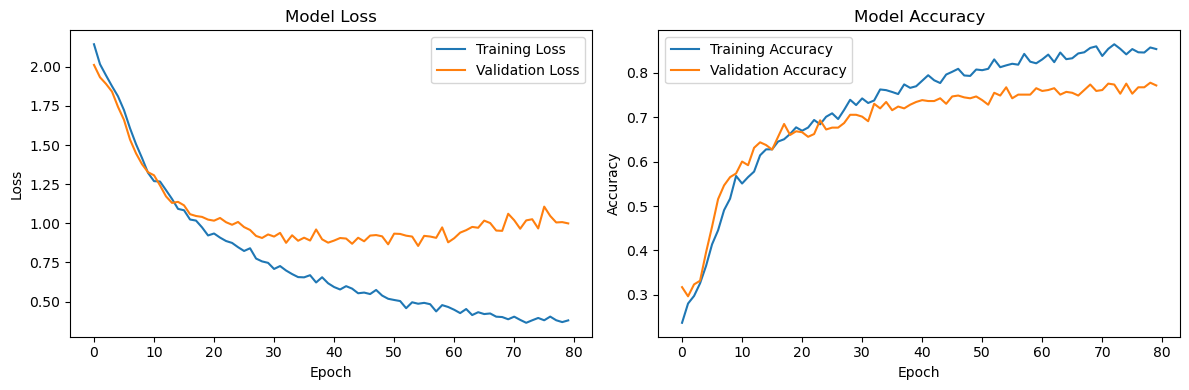

In [18]:
# Evaluate the model
test_loss_cnn_api, test_accuracy_cnn_api = model_cnn_api.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api.history['loss'], label='Training Loss')
plt.plot(history_cnn_api.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


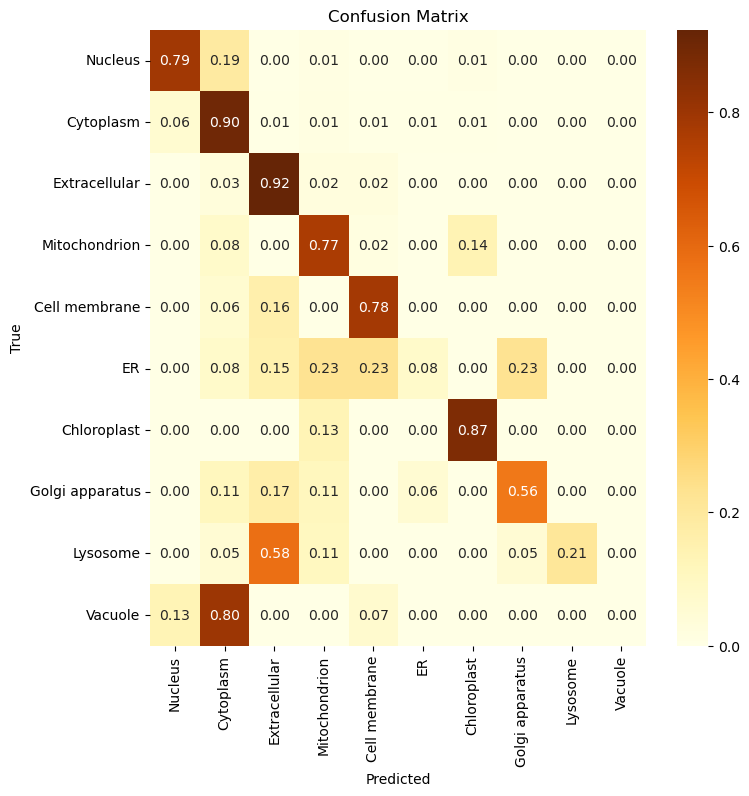

In [19]:
# Make predictions
y_pred = model_cnn_api.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Save the model
# model_cnn_api.save('../res/model_cnn_api.h5')

### ResNet

In [21]:
# Define the residual block achitecture
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size = 1)(x)
    
    # Second convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size = kernel_size, 
               padding="same",
               strides = stride)(x)

    output = Add()([shortcut, x])
    return output

In [22]:
# Build the ResNet model
def resnet_model(input_shape=(400, 20), num_blocks=2):
    inputs = Input(shape=input_shape)
    
    residual_i = inputs
    
    for _ in range(num_blocks):
        residual_i = residual_block(residual_i, 20)
        
    gavg_1 = AveragePooling1D(2, strides=1)(residual_i)
    
    flat_1 = Flatten()(gavg_1)
    
    output = Dense(num_classes, activation="softmax")(flat_1)
    
    model = Model(inputs=inputs, outputs=output)
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
                                                        
    return model

# Create the model
model_resnet = resnet_model()
model_resnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ input_layer_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 400, 20)   │        420 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 400, 20)   │      1,220 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 400, 20)   │          0 │ input_layer_3[0]… │
│                     │                   │            │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 400, 20)   │        420 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 400, 20)   │      1,220 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 400, 20)   │          0 │ add[0][0],        │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_2 │ (None, 399, 20)   │          0 │ add_1[0][0]       │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 7980)      │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │     79,810 │ flatten_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 83,410 (325.82 KB)

 Trainable params: 83,250 (325.20 KB)

 Non-trainable params: 160 (640.00 B)

In [23]:
history_resnet = model_resnet.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2377 - loss: 2.2763 - val_accuracy: 0.3649 - val_loss: 2.2054
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6115 - loss: 1.2093 - val_accuracy: 0.3402 - val_loss: 2.1382
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7777 - loss: 0.8075 - val_accuracy: 0.2845 - val_loss: 2.0670
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8571 - loss: 0.5704 - val_accuracy: 0.2907 - val_loss: 1.9925
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9140 - loss: 0.3744 - val_accuracy: 0.2351 - val_loss: 1.9612
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9521 - loss: 0.2699 - val_accuracy: 0.2330 - val_loss: 1.9380
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9624 - loss: 0.2210 - val_accuracy: 0.2784 - val_loss: 1.9629
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9786 - loss: 0.1638 - val_accuracy: 0.2825 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7366 - loss: 1.4386
Test accuracy: 0.7402


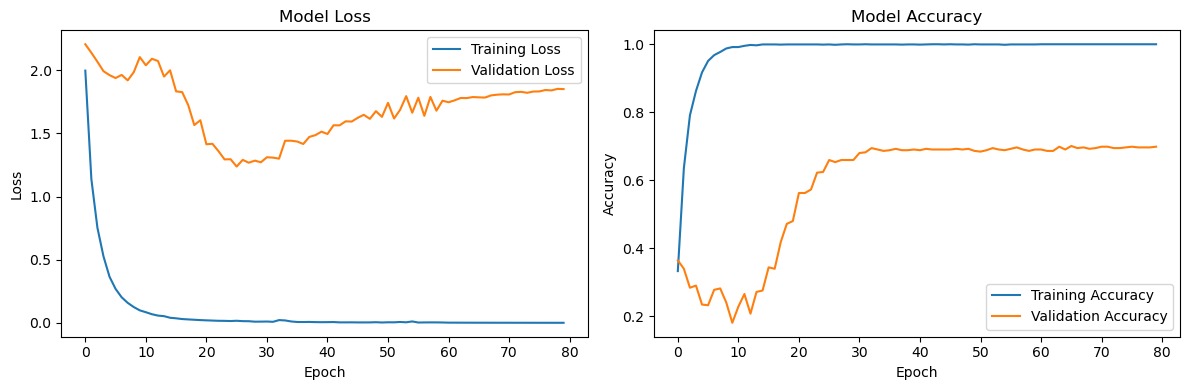

In [24]:
# Evaluate the model
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


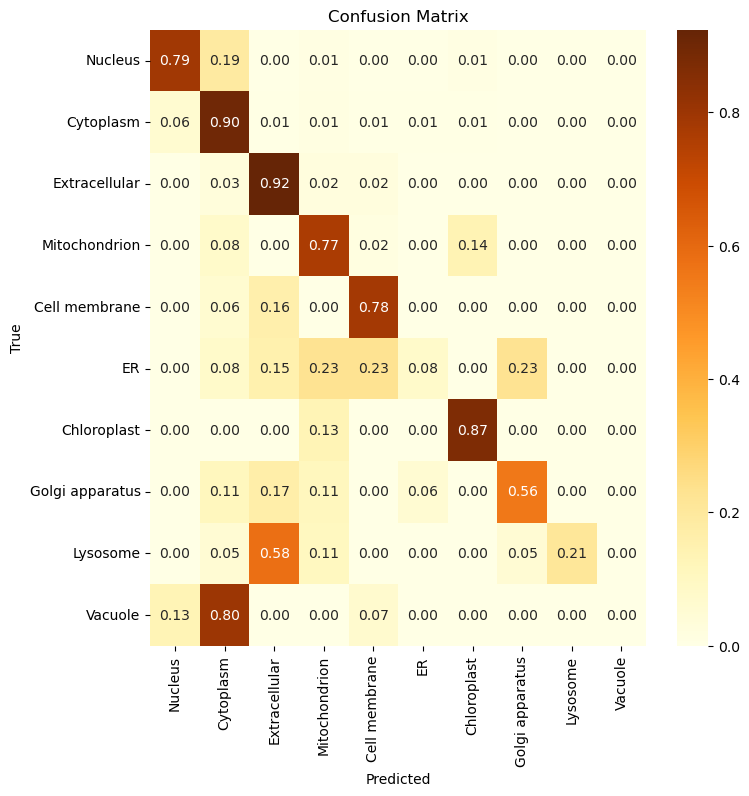

In [25]:
# Make predictions
y_pred = model_cnn_api.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Save the model
# model_resnet.save('../res/model_resnet.h5')

## Include class weights

In [27]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(np.argmax(y_train, axis=1)),
                                        y = np.argmax(y_train, axis=1)
                                    )
class_weights = dict(enumerate(class_weights))
print(f'Class Weights: {class_weights}\n')

Class Weights: {0: 0.7168639053254438, 1: 0.427336860670194, 2: 0.45289719626168223, 3: 1.0399141630901287, 4: 0.8501754385964913, 5: 3.846031746031746, 6: 1.0816964285714286, 7: 4.106779661016949, 8: 4.038333333333333, 9: 4.106779661016949}



### DNN

In [28]:
# Create the model 
model_dnn_cw = dnn_model()

history_dnn_cw = model_dnn_cw.fit(x_train, y_train, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2,
                    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1359 - loss: 2.2758 - val_accuracy: 0.2701 - val_loss: 2.2249
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2902 - loss: 2.0767 - val_accuracy: 0.2969 - val_loss: 2.1139
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3281 - loss: 1.9866 - val_accuracy: 0.3979 - val_loss: 1.9758
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4058 - loss: 1.8306 - val_accuracy: 0.3979 - val_loss: 1.9386
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4663 - loss: 1.6894 - val_accuracy: 0.5031 - val_loss: 1.8162
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5210 - loss: 1.5448 - val_accuracy: 0.5423 - val_loss: 1.7417
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5463 - loss: 1.4759 - val_accuracy: 0.5959 - val_loss: 1.6652
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6269 - loss: 1.3226 - val_accuracy: 0.6247 - val_loss

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7543 - loss: 0.8209 
Test accuracy: 0.7433


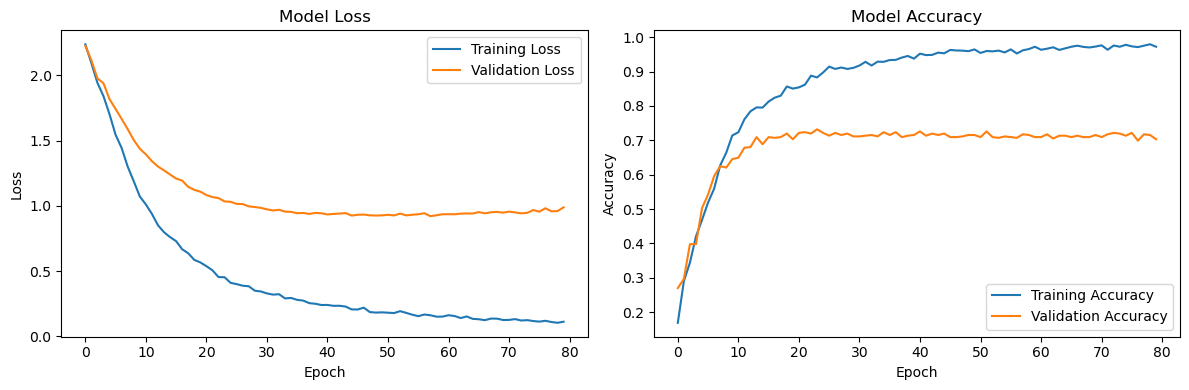

In [29]:
# Evaluate the model
test_loss_dnn_cw, test_accuracy_dnn_cw = model_dnn_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn_cw.history['loss'], label='Training Loss')
plt.plot(history_dnn_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


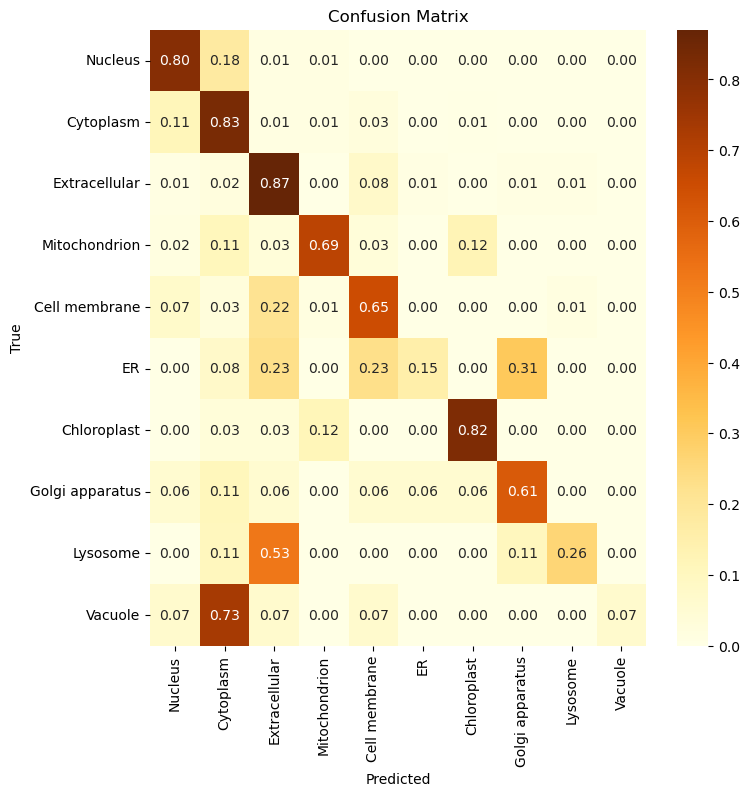

In [30]:
# Make predictions
y_pred = model_dnn_cw.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Save the model
# model_dnn_cw.save('../res/model_dnn_cw.h5')

### CNN

In [32]:
model_cnn_cw = cnn_model()

history_cnn_cw = model_cnn_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.1427 - loss: 2.8141 - val_accuracy: 0.1794 - val_loss: 2.3069
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.2625 - loss: 2.1744 - val_accuracy: 0.1629 - val_loss: 2.3750
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3143 - loss: 2.0274 - val_accuracy: 0.1546 - val_loss: 2.4357
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4102 - loss: 1.7968 - val_accuracy: 0.0619 - val_loss: 2.5525
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4496 - loss: 1.5064 - val_accuracy: 0.0454 - val_loss: 2.6474
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4958 - loss: 1.4329 - val_accuracy: 0.0928 - val_loss: 2.7895
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5211 - loss: 1.2613 - val_accuracy: 0.0907 - val_loss: 2.8825
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6001 - loss: 1.1104 - val_accuracy: 0.2124 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8183 - loss: 0.6739
Test accuracy: 0.8220


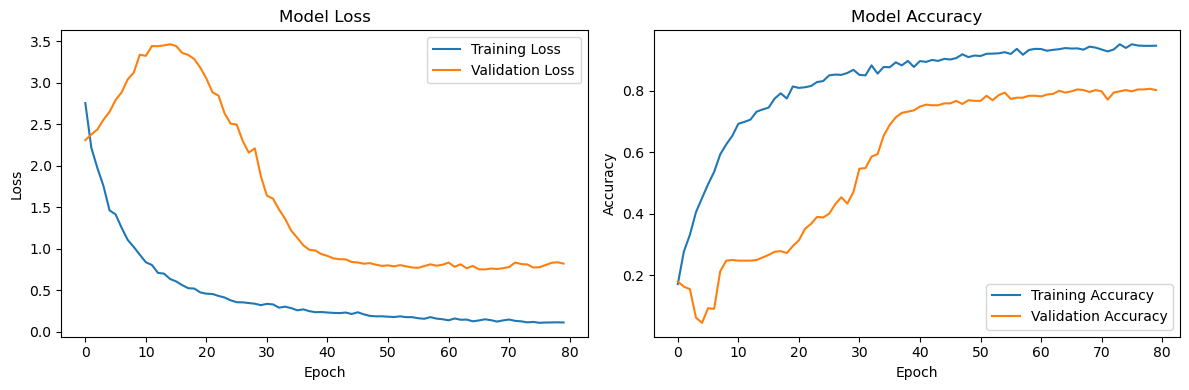

In [33]:
# Evaluate the model
test_loss_cnn_cw, test_accuracy_cnn_cw = model_cnn_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_cw.history['loss'], label='Training Loss')
plt.plot(history_cnn_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


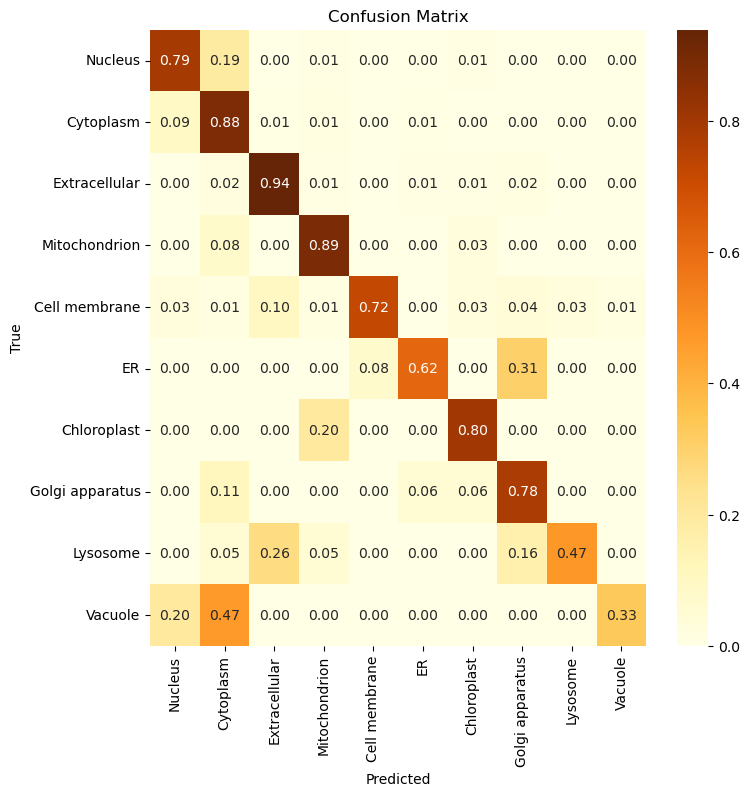

In [34]:
# Make predictions
y_pred = model_cnn_cw.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Save the model
# model_cnn_cw.save('../res/model_cnn_cw.h5')

### CNN - functional API

In [36]:
model_cnn_api_cw = cnn_api_model()
history_cnn_api_cw = model_cnn_api_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.0971 - loss: 2.2378 - val_accuracy: 0.1155 - val_loss: 2.2455
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.1388 - loss: 2.1229 - val_accuracy: 0.1443 - val_loss: 2.2279
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1444 - loss: 2.0624 - val_accuracy: 0.1794 - val_loss: 2.1420
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1875 - loss: 2.0236 - val_accuracy: 0.1897 - val_loss: 2.1043
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.2249 - loss: 2.0813 - val_accuracy: 0.2825 - val_loss: 2.0245
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.2818 - loss: 1.9671 - val_accuracy: 0.2948 - val_loss: 1.9567
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.3139 - loss: 1.8076 - val_accuracy: 0.3814 - val_loss: 1.9139
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3626 - loss: 1.7143 - val_accuracy: 0.5113 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7952 - loss: 0.7525
Test accuracy: 0.8063


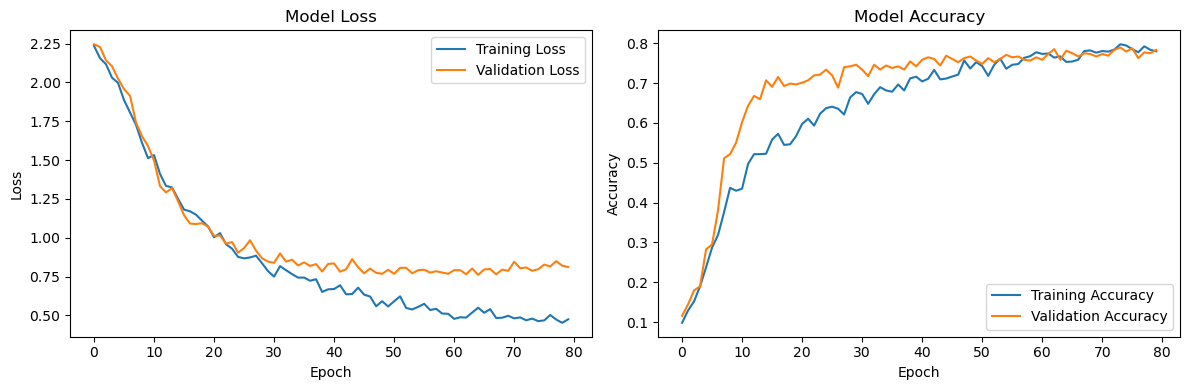

In [37]:
# Evaluate the model
test_loss_cnn_api_cw, test_accuracy_cnn_api_cw = model_cnn_api_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api_cw.history['loss'], label='Training Loss')
plt.plot(history_cnn_api_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


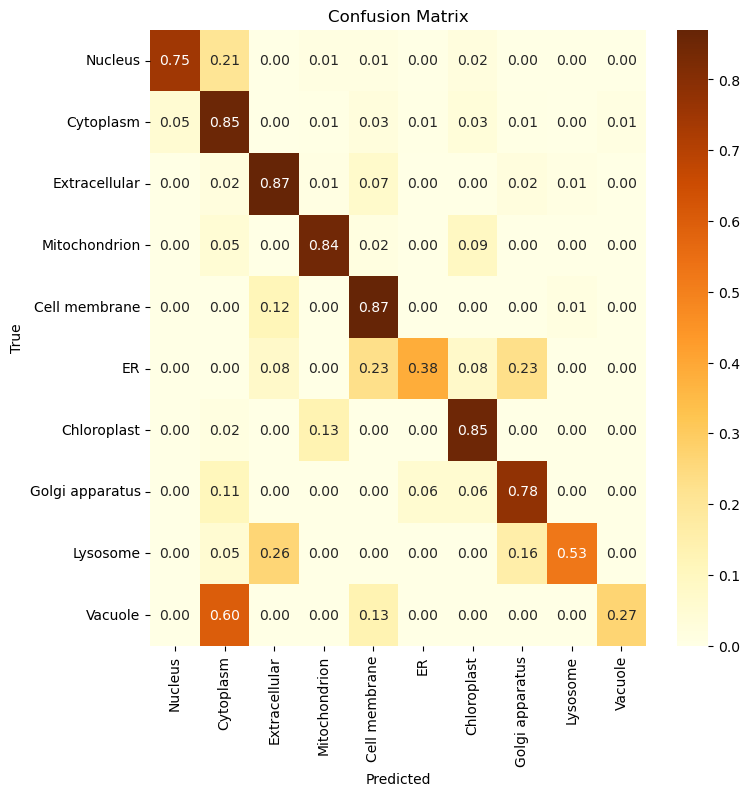

In [38]:
# Make predictions
y_pred = model_cnn_api_cw.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# Save the model
# model_cnn_api_cw.save('../res/model_cnn_api_cw.h5')

### ResNet

In [40]:
model_resnet_cw = resnet_model()
history_resnet_cw = model_resnet_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.1725 - loss: 2.5869 - val_accuracy: 0.2928 - val_loss: 2.1867
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5312 - loss: 1.3314 - val_accuracy: 0.2907 - val_loss: 2.1389
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6761 - loss: 0.9132 - val_accuracy: 0.2454 - val_loss: 2.1067
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7952 - loss: 0.6125 - val_accuracy: 0.1938 - val_loss: 2.0765
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8742 - loss: 0.4315 - val_accuracy: 0.1649 - val_loss: 2.1273
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9138 - loss: 0.3138 - val_accuracy: 0.1588 - val_loss: 2.0900
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9448 - loss: 0.2239 - val_accuracy: 0.1670 - val_loss: 2.0792
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9604 - loss: 0.1904 - val_accuracy: 0.1567 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7319 - loss: 1.4357
Test accuracy: 0.7118


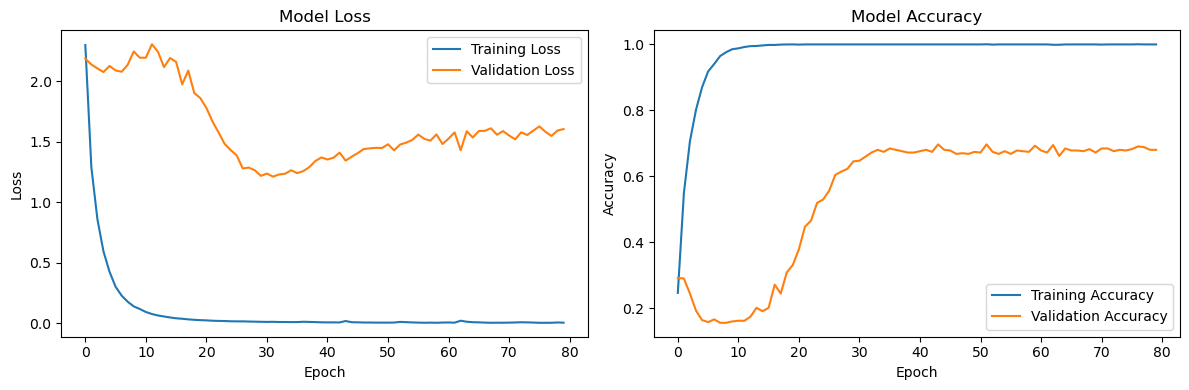

In [41]:
# Evaluate the model
test_loss_resnet_cw, test_accuracy_resnet_cw = model_resnet_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet_cw.history['loss'], label='Training Loss')
plt.plot(history_resnet_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


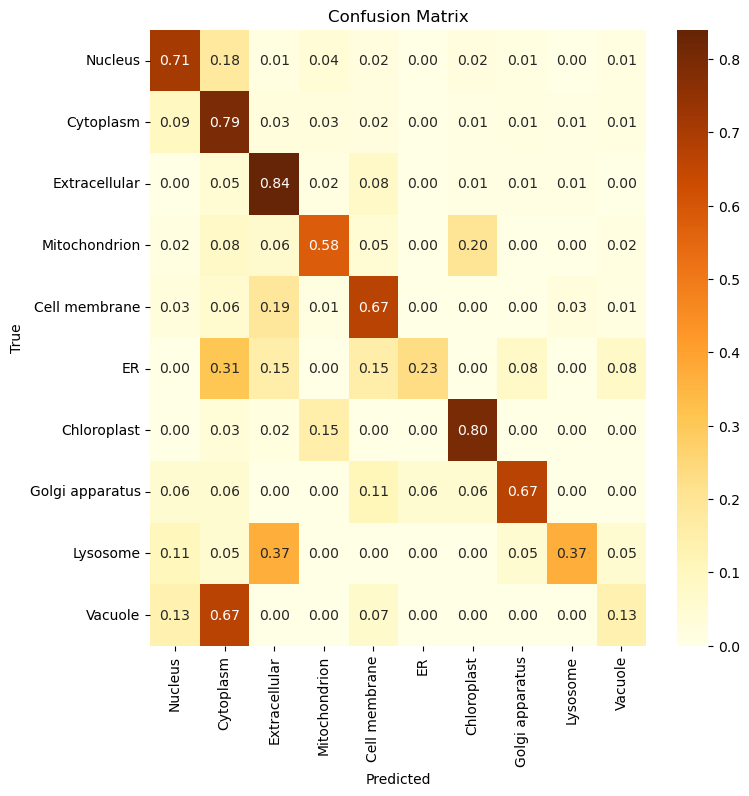

In [42]:
# Make predictions
y_pred = model_resnet_cw.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Save the model
# model_resnet_cw.save('../res/model_resnet_cw.h5')

## Data augmentation

In [44]:
def selective_masking(x, mask_prob=0.1):
    mask = np.random.random(x.shape) < mask_prob
    x_masked = x.copy()
    x_masked[mask] = 0
    return x_masked

def pssm_smoothing(x, sigma=1.0):
    return gaussian_filter1d(x, sigma=sigma, axis=0)

def substring_sampling(x, min_length=0.8):
    seq_length = x.shape[0]
    start = np.random.randint(0, int(seq_length * (1 - min_length)))
    end = start + int(seq_length * min_length) + np.random.randint(0, int(seq_length * (1 - min_length)))
    return x[start:end]

def augment_pssm_data(x_train, y_train, target_samples=500):
    class_counts = {label: np.sum(y_train == label) for label in np.unique(y_train)}
    
    x_aug, y_aug = [], []
    
    for class_label, count in class_counts.items():
        class_indices = np.where(y_train == class_label)[0]
        x_class = x_train[class_indices]
        
        if count < target_samples:
            augment_factor = int(np.ceil((target_samples - count) / count))
            
            for i in range(len(x_class)):
                # Original sequence
                x_aug.append(x_class[i])
                y_aug.append(class_label)
                
                # Augmented sequences
                for _ in range(augment_factor):
                    aug_seq = x_class[i].copy()
                    
                    # Apply augmentation techniques
                    aug_type = np.random.choice(['mask', 'smooth', 'substring'])
                    if aug_type == 'mask':
                        aug_seq = selective_masking(aug_seq)
                    elif aug_type == 'smooth':
                        aug_seq = pssm_smoothing(aug_seq)
                    elif aug_type == 'substring':
                        aug_seq = substring_sampling(aug_seq)
                    
                    x_aug.append(aug_seq)
                    y_aug.append(class_label)
        else:
            # For classes that already have enough samples, just add the original data
            x_aug.extend(x_class)
            y_aug.extend([class_label] * len(x_class))
    
    return x_aug, np.array(y_aug)

# Import the data
x_train_aug = train['X_train']
y_train_aug = train['y_train']

# Augment the data
x_train_augmented, y_train_augmented = augment_pssm_data(x_train_aug, y_train_aug, target_samples=500)

# Pad sequences to the same length
max_length = max(seq.shape[0] for seq in x_train_augmented)
x_train_aug_padded = pad_sequences(x_train_augmented, maxlen=max_length, padding='post', dtype='float32')

# Shuffle the augmented dataset
indices = np.arange(len(x_train_aug_padded))
np.random.shuffle(indices)
x_train_aug = x_train_aug_padded[indices]
y_train_aug = y_train_augmented[indices]

# Class Distribution
unique, counts = np.unique(y_train_aug, return_counts=True)
print("\nClass distribution in y_train_aug:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

# Convert labels to categorical
num_classes = len(np.unique(y_train_aug))
y_train_aug = to_categorical(y_train_aug, num_classes)


Class distribution in y_train_aug:
Class 0: 676 samples
Class 1: 567 samples
Class 2: 535 samples
Class 3: 699 samples
Class 4: 570 samples
Class 5: 504 samples
Class 6: 672 samples
Class 7: 531 samples
Class 8: 540 samples
Class 9: 531 samples


### DNN

In [45]:
# Create the model 
model_dnn_aug = dnn_model()

history_dnn_aug = model_dnn_aug.fit(x_train_aug, y_train_aug, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1596 - loss: 2.2419 - val_accuracy: 0.4069 - val_loss: 2.0332
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3416 - loss: 1.9678 - val_accuracy: 0.5442 - val_loss: 1.7733
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4785 - loss: 1.7009 - val_accuracy: 0.6755 - val_loss: 1.5420
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5925 - loss: 1.4729 - val_accuracy: 0.7107 - val_loss: 1.3691
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6425 - loss: 1.2923 - val_accuracy: 0.7451 - val_loss: 1.2251
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7044 - loss: 1.1462 - val_accuracy: 0.7725 - val_loss: 1.1007
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7237 - loss: 1.0381 - val_accuracy: 0.7777 - val_loss: 1.0158
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7657 - loss: 0.9266 - val_accuracy: 0.7897 - val_loss:

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.7127 - loss: 1.2187
Test accuracy: 0.7433


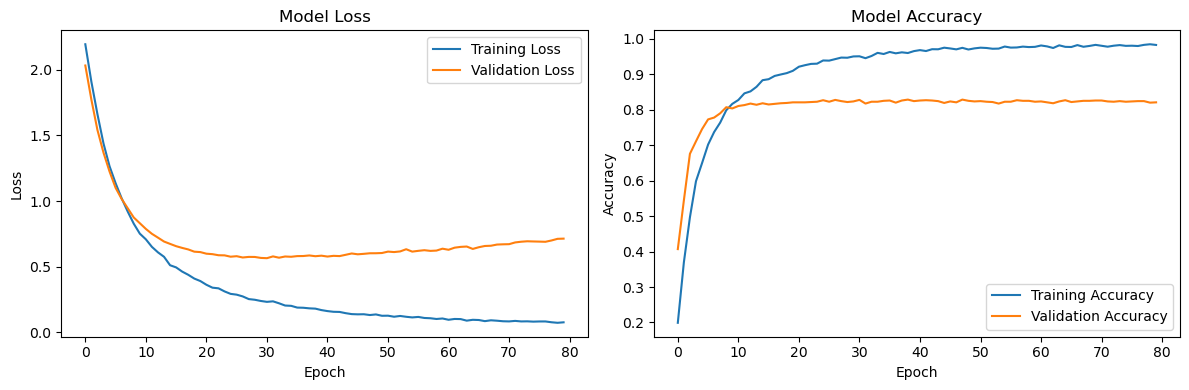

In [46]:
# Evaluate the model
test_loss_dnn_aug, test_accuracy_dnn_aug = model_dnn_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn_aug.history['loss'], label='Training Loss')
plt.plot(history_dnn_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


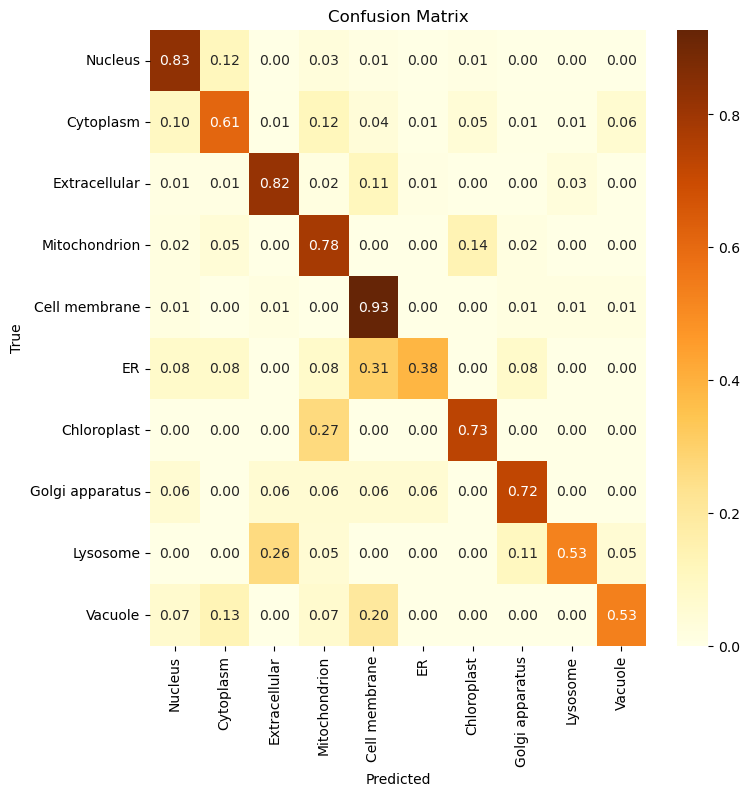

In [47]:
# Make predictions
y_pred = model_dnn_aug.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Save the model
# model_dnn_aug.save('../res/model_dnn_aug.h5')

### CNN

In [49]:
model_cnn_aug = cnn_model()

history_cnn_aug = model_cnn_aug.fit(
    x_train_aug, y_train_aug,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1666 - loss: 2.7642 - val_accuracy: 0.1116 - val_loss: 2.2833
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3275 - loss: 2.0796 - val_accuracy: 0.1056 - val_loss: 2.3928
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4715 - loss: 1.6253 - val_accuracy: 0.1056 - val_loss: 2.7123
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5782 - loss: 1.2649 - val_accuracy: 0.1056 - val_loss: 2.9271
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6431 - loss: 1.0841 - val_accuracy: 0.1056 - val_loss: 3.3453
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6963 - loss: 0.9304 - val_accuracy: 0.1056 - val_loss: 3.6262
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7137 - loss: 0.8414 - val_accuracy: 0.1073 - val_loss: 3.6073
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7399 - loss: 0.7845 - val_accuracy: 0.1073 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7949 - loss: 0.8051
Test accuracy: 0.8236


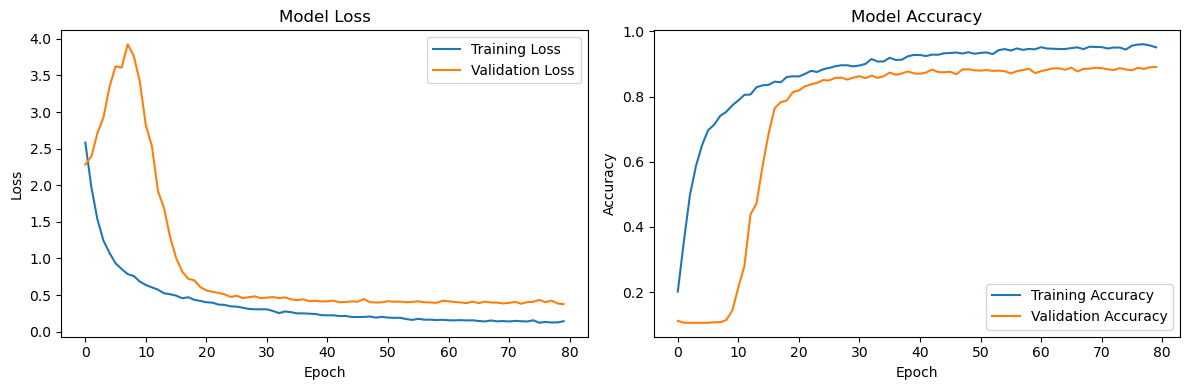

In [50]:
# Evaluate the model
test_loss_cnn_aug, test_accuracy_cnn_aug = model_cnn_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_aug.history['loss'], label='Training Loss')
plt.plot(history_cnn_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


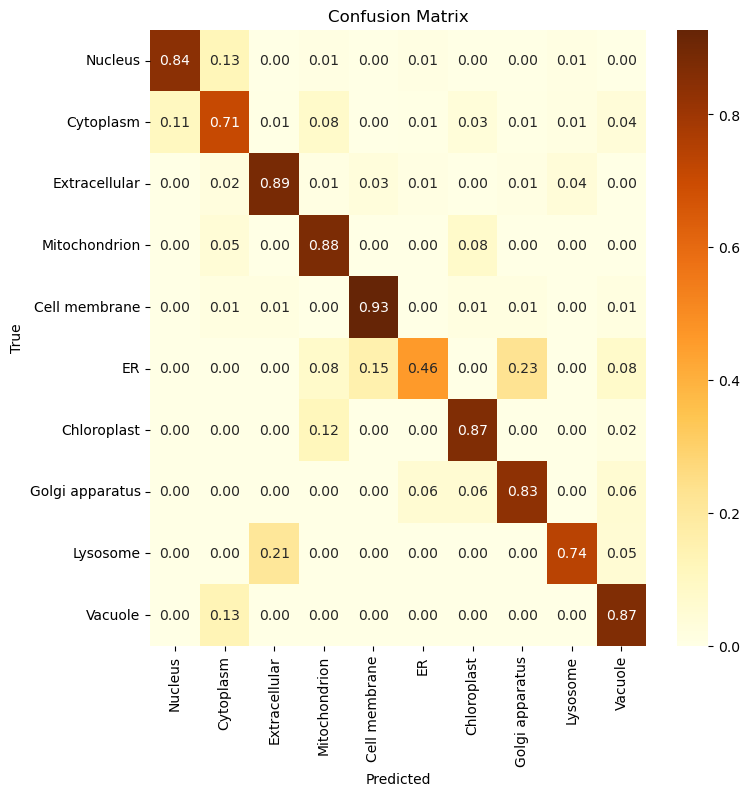

In [51]:
# Make predictions
y_pred = model_cnn_aug.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [52]:
# Save the model
# model_cnn_aug.save('../res/model_cnn_aug.h5')

### CNN - functional API

In [53]:
model_cnn_api_aug = cnn_api_model()
history_cnn_api_aug = model_cnn_api_aug.fit(
    x_train_aug, y_train_aug,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.1538 - loss: 2.2550 - val_accuracy: 0.3133 - val_loss: 2.1408
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2546 - loss: 2.1180 - val_accuracy: 0.4515 - val_loss: 1.9113
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3422 - loss: 1.9388 - val_accuracy: 0.5554 - val_loss: 1.6518
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4423 - loss: 1.6907 - val_accuracy: 0.6343 - val_loss: 1.3685
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5213 - loss: 1.4512 - val_accuracy: 0.7039 - val_loss: 1.1073
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5736 - loss: 1.3034 - val_accuracy: 0.7348 - val_loss: 1.0041
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6211 - loss: 1.1620 - val_accuracy: 0.7674 - val_loss: 0.9297
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6449 - loss: 1.0806 - val_accuracy: 0.7588 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7893 - loss: 1.1665
Test accuracy: 0.8205


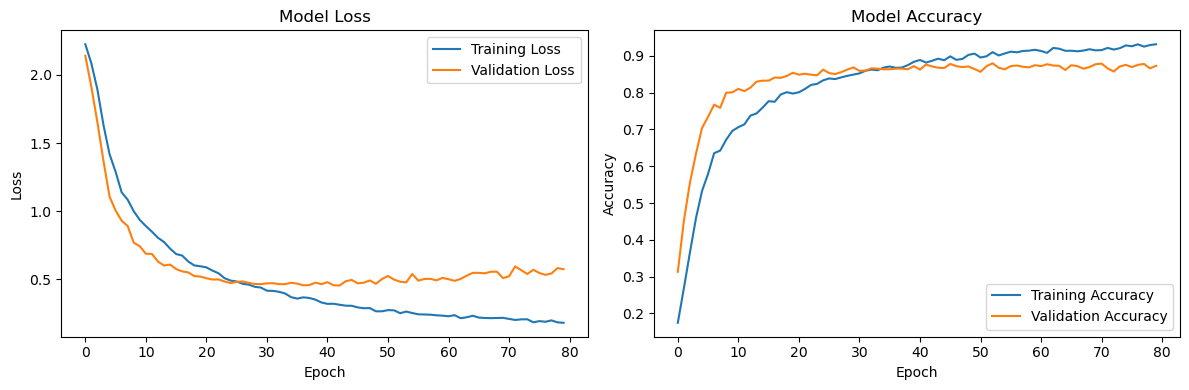

In [54]:
# Evaluate the model
test_loss_cnn_api_aug, test_accuracy_cnn_api_aug = model_cnn_api_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api_aug.history['loss'], label='Training Loss')
plt.plot(history_cnn_api_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


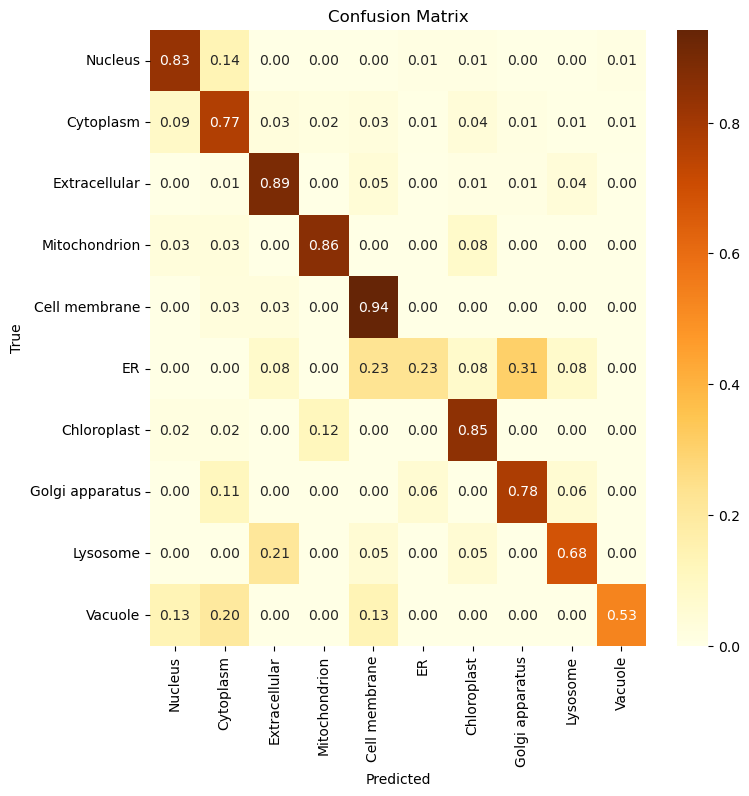

In [55]:
# Make predictions
y_pred = model_cnn_api_aug.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [56]:
# Save the model
# model_cnn_api_aug.save('../res/model_cnn_api_aug.h5')

### ResNet

In [57]:
model_resnet_aug = resnet_model()
history_resnet_aug = model_resnet_aug.fit(
    x_train_aug, y_train_aug,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2631 - loss: 2.1697 - val_accuracy: 0.2223 - val_loss: 2.1394
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7287 - loss: 0.9508 - val_accuracy: 0.2189 - val_loss: 2.0744
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8512 - loss: 0.5632 - val_accuracy: 0.1794 - val_loss: 2.2151
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9120 - loss: 0.3728 - val_accuracy: 0.1691 - val_loss: 2.3603
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9474 - loss: 0.2638 - val_accuracy: 0.2052 - val_loss: 2.2641
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9697 - loss: 0.1959 - val_accuracy: 0.2807 - val_loss: 2.1827
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9799 - loss: 0.1414 - val_accuracy: 0.4361 - val_loss: 1.9123
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9890 - loss: 0.1074 - val_accuracy: 0.4918 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7101 - loss: 2.0478
Test accuracy: 0.7228


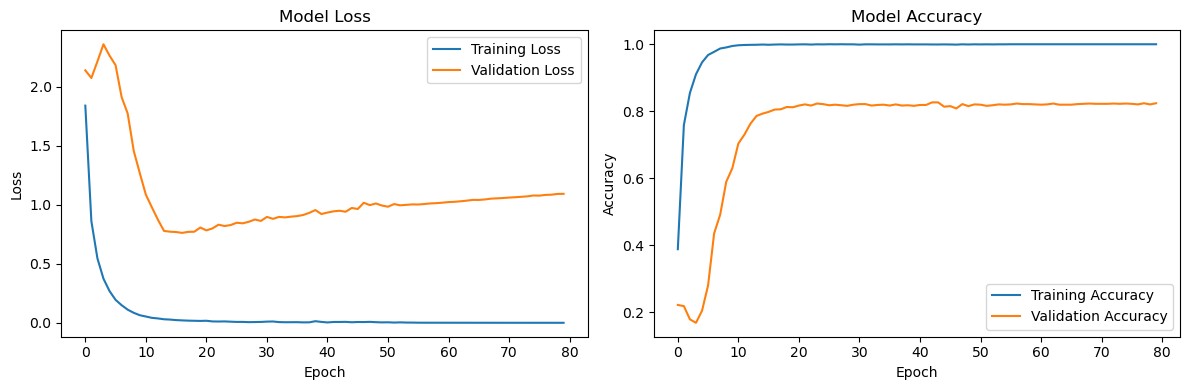

In [58]:
# Evaluate the model
test_loss_resnet_aug, test_accuracy_resnet_aug = model_resnet_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet_aug.history['loss'], label='Training Loss')
plt.plot(history_resnet_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


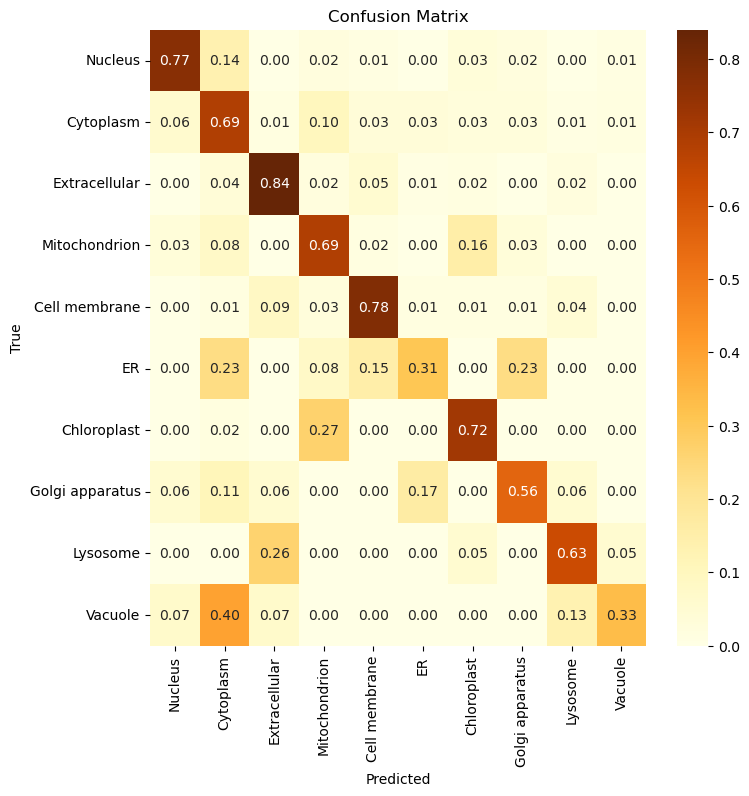

In [59]:
# Make predictions
y_pred = model_resnet_aug.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [60]:
# Save the model
# model_resnet_aug.save('../res/model_resnet_aug.h5')

# Comparison

Table of Accuracy Values:


Method,Base,CW,Aug
Model,,,
CNN,0.8205,0.8220,0.8236
CNN_API,0.7906,0.8063,0.8205
DNN,0.7213,0.7433,0.7433
ResNet,0.7402,0.7118,0.7228


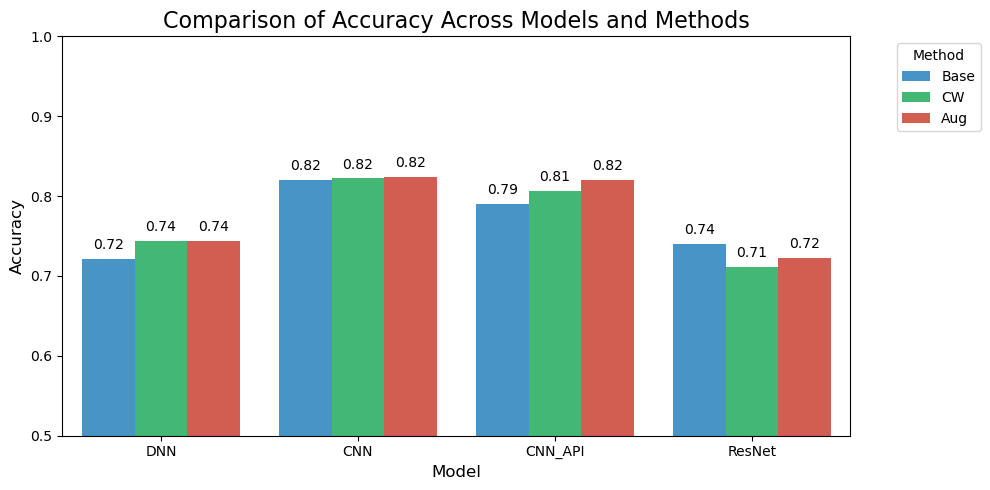

In [61]:
data = {
    'Model': ['DNN', 'DNN', 'DNN', 'CNN', 'CNN', 'CNN', 'CNN_API', 'CNN_API', 'CNN_API', 'ResNet', 'ResNet', 'ResNet'],
    'Method': ['Base', 'CW', 'Aug', 'Base', 'CW', 'Aug', 'Base', 'CW', 'Aug', 'Base', 'CW', 'Aug'],
    'Accuracy': [test_accuracy_dnn, test_accuracy_dnn_cw, test_accuracy_dnn_aug,
                 test_accuracy_cnn, test_accuracy_cnn_cw, test_accuracy_cnn_aug,
                 test_accuracy_cnn_api, test_accuracy_cnn_api_cw, test_accuracy_cnn_api_aug,
                 test_accuracy_resnet, test_accuracy_resnet_cw, test_accuracy_resnet_aug]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Pivot the table to get the desired format
pivot_df = df.pivot(index='Model', columns='Method', values='Accuracy')

# Reorder the columns
pivot_df = pivot_df[['Base', 'CW', 'Aug']]

# Display the table
print("Table of Accuracy Values:")
display(pivot_df.style.format("{:.4f}").highlight_max(axis=1))

# Function to add value labels on bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        label = f"{y_value:.2f}"
        
        ax.annotate(label, (x_value, y_value), xytext=(0, spacing),
                    textcoords="offset points", ha='center', va='bottom')

colors = ['#3498db', '#2ecc71', '#e74c3c']

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Model', y='Accuracy', hue='Method', data=df, palette=colors)
plt.title('Comparison of Accuracy Across Models and Methods', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.5, 1.0)  # Adjust this range based on your actual accuracy values
add_value_labels(ax)
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Cross-validation of the most performant model

In [62]:
training = KerasClassifier(build_fn=model_cnn_aug,
                           epochs=80, batch_size=128, verbose=0)

kfold = KFold(n_splits=5, shuffle=True)

cv_results = cross_val_score(training, x_train_aug, 
                             y_train_aug, cv=kfold)

/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/opt/homebrew/Caskroom/miniconda/base/envs/aiao-env/lib/python3.12/site-packages/sciker

In [63]:
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

Cross validation accuracies: [0.90643777 0.91416309 0.9304721  0.9167382  0.91416309]
Results Cross validation : 91.64% (0.78%)
